In [40]:
!nvidia-smi

Fri Dec 15 23:50:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    67W /  75W |   6264MiB /  7680MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

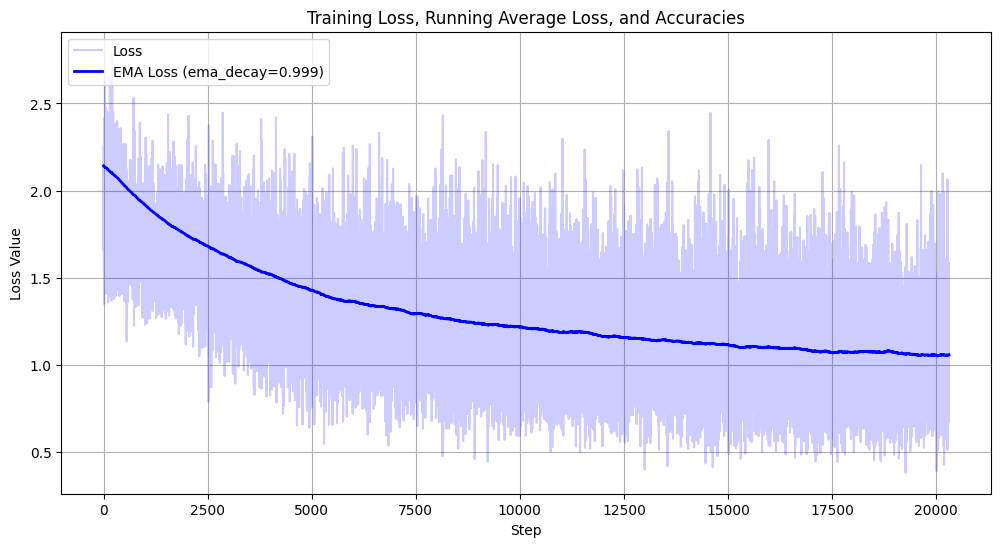

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def calculate_ema(values, alpha):
    ema_values = []
    ema = np.mean(values[:1])
    for value in values:
        ema = alpha * ema + (1 - alpha) * value
        ema_values.append(ema)
    return ema_values

# Adjusted patterns to match the new log format
loss_pattern = re.compile(r'\[\d+, +(\d+)\] loss: ([\d.]+)')
accuracy_pattern = re.compile(r'TMA Accuracy: ([\d.]+) \| Non-TMA Accuracy: ([\d.]+) \| Overall Accuracy: ([\d.]+)')

# Lists to store the extracted data
steps = []
losses = []
tma_accuracies = []
non_tma_accuracies = []
overall_accuracies = []
accuracy_steps = []

last_step = None

# Reading the file contents
# file_path = 'logs/vit/fold_0_pt_2.txt'  # Replace with the path to your file
# file_path = 'logs/vit/fold_2.txt'  # Replace with the path to your file
# file_path = 'logs/convnextv2/fold_2.txt'  # Replace with the path to your file
# file_path = 'logs/convnextv2_base/fold_3.txt'  # Replace with the path to your file
# file_path = 'logs/convnextv2_large/fold_3.txt'  # Replace with the path to your file
file_path = 'logs/eva02_base/fold_1.txt'  # Replace with the path to your file
# file_path = 'logs/eva02_base/fold_4 (the oldie but the best).txt'  # Replace with the path to your file
# file_path = 'logs/eva02_base/fold_4_newer_but_not_great.txt'  # Replace with the path to your file
# file_path = 'logs/eva02_base_2048/fold_4.txt'  # Replace with the path to your file
# file_path = 'logs/vit_base_pretrained/fold_4_224.txt'  # Replace with the path to your file
# file_path = 'logs/vit_base_pretrained/fold_3.txt'  # Replace with the path to your file
# file_path = 'logs/vit_self_supervised/fold_4.txt'  # Replace with the path to your file
# file_path = 'logs/vit_base_pretrained/fold_4_fast.txt'  # Replace with the path to your file
with open(file_path, 'r') as file:
    training_log = file.readlines()

# Parsing the file
for line in training_log:
    # Extracting loss and step
    loss_match = loss_pattern.match(line)
    if loss_match:
        step, loss = map(float, loss_match.groups())
        steps.append(step)
        losses.append(loss)
        last_step = step

    # Extracting accuracies
    accuracy_match = accuracy_pattern.match(line)
    if accuracy_match and last_step is not None:
        tma_accuracy, non_tma_accuracy, overall_accuracy = map(float, accuracy_match.groups())
        tma_accuracies.append(tma_accuracy)
        non_tma_accuracies.append(non_tma_accuracy)
        overall_accuracies.append(overall_accuracy)
        accuracy_steps.append(last_step)

# Creating DataFrames
loss_data = pd.DataFrame({
    'Step': steps,
    'Loss': losses
})
accuracy_data = pd.DataFrame({
    'Step': accuracy_steps,
    'TMA Accuracy': tma_accuracies,
    'Non-TMA Accuracy': non_tma_accuracies,
    'Overall Accuracy': overall_accuracies
})

# Calculating EMA loss
ema_decay = 0.999  # decay factor for EMA
loss_data['EMA Loss'] = calculate_ema(loss_data['Loss'], ema_decay)

# Merging the loss and accuracy data
merged_data = pd.merge(loss_data, accuracy_data, on='Step', how='left')
merged_data.fillna(method='ffill', inplace=True)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Loss and Running Average Loss
ax1.plot(merged_data['Step'], merged_data['Loss'], label='Loss', alpha=0.2, color='blue')
ax1.plot(merged_data['Step'], merged_data['EMA Loss'], label=f'EMA Loss (ema_decay={ema_decay})', linewidth=2, color='blue')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# # Accuracies
# ax2 = ax1.twinx()
# ax2.plot(merged_data['Step'], merged_data['TMA Accuracy'], label='TMA Accuracy', color='red')
# ax2.plot(merged_data['Step'], merged_data['Non-TMA Accuracy'], label='Non-TMA Accuracy', color='blue')
# ax2.plot(merged_data['Step'], merged_data['Overall Accuracy'], label='Overall Accuracy', color='green')
# ax2.set_ylabel('Accuracy')
# ax2.legend(loc='lower right')

# Title
plt.title('Training Loss, Running Average Loss, and Accuracies')

# Display the plot
plt.show()

In [149]:
loss_data

,Step,Loss,EMA Loss
0,0.0,12.696,12.696000
1,1.0,12.338,12.695642
2,2.0,11.916,12.694862
3,3.0,13.737,12.695904
4,4.0,12.463,12.695672
...,...,...,...
222,222.0,4.252,11.566514
223,223.0,4.746,11.559693
224,224.0,4.458,11.552591
225,225.0,3.933,11.544972


In [150]:
loss_data['Loss'].iloc[-100:].mean()

4.85727

In [151]:
loss_data['EMA Loss'].idxmin(), loss_data['EMA Loss'].min()

(226, 11.537813835415939)

In [141]:
loss_data.iloc[:642]

,Step,Loss,EMA Loss
0,0.0,12.696,9.663416
1,1.0,12.338,9.666090
2,2.0,11.916,9.668340
3,3.0,13.737,9.672409
4,4.0,12.463,9.675199
...,...,...,...
206,206.0,4.404,9.215670
207,207.0,4.456,9.210911
208,208.0,4.405,9.206105
209,209.0,4.229,9.201128
